# Тестовое задание в компанию OneCell

### Импорты

In [46]:
# !pip install -r requirements.txt

In [47]:
import bz2
import math
import os
import shutil
import zipfile

import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import requests
import supervisely as sly
from icrawler.builtin import GoogleImageCrawler
from kaggle.api.kaggle_api_extended import KaggleApi
from PIL import Image, ImageOps
from IPython.display import Image
from sklearn.metrics import r2_score

# 1. Базовая работа с python/numpy

1. Скачайте 10-20 изображений с лицами из интернета какими удобно средствами (например)

2. Воспользуйтесь одним из готовых face-detector/face-landmark-detector для того, чтобы на выбранных изображениях найти лицо и ключевые точки на лице. Можно для этого взять связку библиотек OpenCV (opencv-python) & dlib (dlib-python). 

3. Результат детектирования лица (bbox) & landmarks (points) визуализировать в jupyter-notebook для первых 5-10 картинок. 
Для визуализации можно использовать matplotlib, например 🕷️


#### Скачиваем изображения из Google

Испльзуем **GoogleImageCrawler** для загрузки изображений.

Переменная **num_img_down** используется для определения количества загружаемых изображений.

In [55]:
num_img_down = 10

# Подготовка папки для хранения изображений
output_dir = 'data/trump_images'

def remove_folder_if_exists(folder_path):
    if os.path.exists(folder_path):
        shutil.rmtree(folder_path)

remove_folder_if_exists(output_dir)

In [56]:
# Создание экземпляра GoogleImageCrawler и загрузка изображений
google_crawler = GoogleImageCrawler(storage={'root_dir': output_dir})
google_crawler.crawl(keyword='Donald Trump', max_num=num_img_down, min_size=(400, 400), max_size=None)

2024-06-26 13:04:48,627 - INFO - icrawler.crawler - start crawling...
2024-06-26 13:04:48,628 - INFO - icrawler.crawler - starting 1 feeder threads...
2024-06-26 13:04:48,630 - INFO - feeder - thread feeder-001 exit
2024-06-26 13:04:48,631 - INFO - icrawler.crawler - starting 1 parser threads...
2024-06-26 13:04:48,631 - INFO - icrawler.crawler - starting 1 downloader threads...
2024-06-26 13:04:49,263 - INFO - parser - parsing result page https://www.google.com/search?q=Donald+Trump&ijn=0&start=0&tbs=&tbm=isch
2024-06-26 13:04:50,417 - INFO - downloader - image #1	https://upload.wikimedia.org/wikipedia/commons/5/56/Donald_Trump_official_portrait.jpg
2024-06-26 13:04:50,583 - INFO - downloader - image #2	https://hips.hearstapps.com/hmg-prod/images/former-u-s-president-donald-trump-speaks-to-reporters-news-photo-1680289458.jpg
2024-06-26 13:04:50,663 - INFO - downloader - image #3	https://cdn.britannica.com/31/149831-050-83A0E45B/Donald-J-Trump-2010.jpg
2024-06-26 13:04:50,752 - INFO - 

2024-06-26 13:04:54,475 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2024-06-26 13:04:54,477 - INFO - parser - thread parser-001 exit


#### Предобработка изображений

Приводим изображения к одному разрешению, так как это поможет однородно визуализировать изображения.

In [50]:
from PIL import Image

def resize_image(image_path, target_size=400):
    with Image.open(image_path) as img:
        if img.height > img.width:
            # Вертикальное изображение
            new_height = target_size
            aspect_ratio = img.width / img.height
            new_width = int(target_size * aspect_ratio)
        else:
            # Горизонтальное изображение
            new_width = target_size
            aspect_ratio = img.height / img.width
            new_height = int(target_size * aspect_ratio)
        
        # Изменяем размер изображения с сохранением пропорций
        img = img.resize((new_width, new_height), Image.Resampling.LANCZOS)
        img.save(image_path)


# Изменение размера всех загруженных изображений
for filename in os.listdir(output_dir):
    if filename.endswith(('.jpg', '.jpeg', '.png')):
        image_path = os.path.join(output_dir, filename)
        resize_image(image_path)

### Модель face-landmark-detector


#### Импортируем модель в проект

In [51]:
folder_path = "models"
file_model = "shape_predictor_68_face_landmarks.dat"

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    print("Создана директория models/")

%cd models

if not os.path.exists(file_model):
    print(f"Скачиваем модель {file_model}")

    url = "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
    compressed_file_path = "shape_predictor_68_face_landmarks.dat.bz2"

    response = requests.get(url, stream=True)

    with open(compressed_file_path, "wb") as f:
        f.write(response.content)

    with bz2.open(compressed_file_path, "rb") as f_in, open(file_model, "wb") as f_out:
        f_out.write(f_in.read())

    os.remove(compressed_file_path)
    print("Файл успешно скачан и распакован:", file_model)
    
else:
    print(f"Модель {file_model} уже существует в папке models/")

%cd ..

/Users/kaledinaoa/Desktop/OneCell/models
Модель shape_predictor_68_face_landmarks.dat уже существует в папке models/
/Users/kaledinaoa/Desktop/OneCell


#### Работа с моделью

In [52]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

2024-06-26 13:04:41,322 - INFO - parser - downloaded image reached max num, thread parser-001 is ready to exit
2024-06-26 13:04:41,557 - INFO - parser - thread parser-001 exit


In [53]:
def print_image(image, detector, image_file, i):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)

    for face in faces:
        x1 = face.left() 
        y1 = face.top()  
        x2 = face.right()
        y2 = face.bottom()
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 1)

        landmarks = predictor(gray, face)
        for n in range(0, 68):
            x = landmarks.part(n).x
            y = landmarks.part(n).y
            cv2.circle(image, (x, y), 1, (0, 255, 255), -1) 

    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"Image {i}: {image_file}")
    plt.show()

Выбираем первые 5 изображений (можно больше/меньше в зависимости от переменной **num_img_print**)

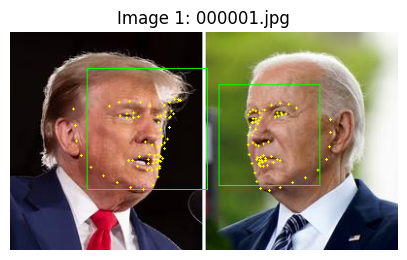

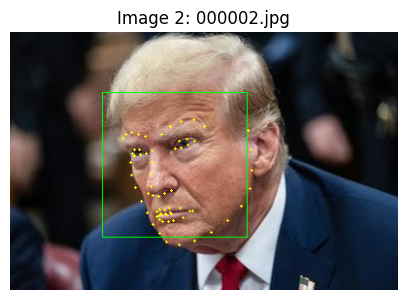

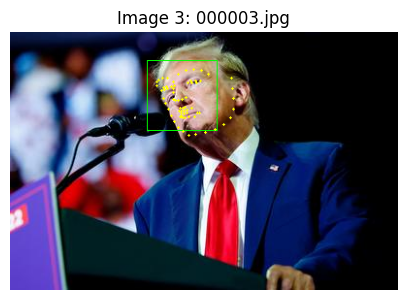

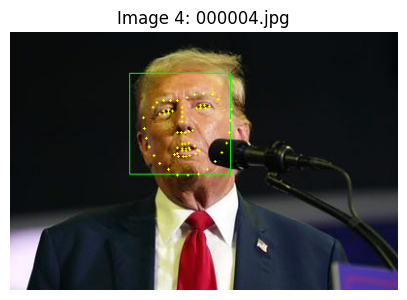

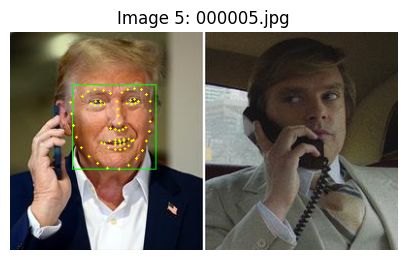

In [54]:
num_img_print = 5

image_dir = output_dir
image_files = sorted(os.listdir(image_dir))

for i, image_file in enumerate(image_files[:min(num_img_print,num_img_down)], start=1):
    image_path = os.path.join(image_dir, image_file)
    image = cv2.imread(image_path)

    if image is None:
        print(f"Skipping {image_file}. Image not loaded.")
        continue

    print_image(image, detector, image_file, i)

# 2. Оценка метрик и валидация моделей

1. Скачайте датасет с kaggle-соревнования Kaggle: Facial Keypoints Detection

2. Задетектируйте при помощи выбранного выше landmark-детектора точки на лицах из этого датасета

3. Посчитайте метрики для Ground-Truth точек которые эквивалентны точкам из модели (в opencv 68-point модель, в kaggle разметка для 15-точек).

4. Подумайте, предложите метрики, которые стоит посчитать для этой задачи. Мы хотим при помощи этих метрик оценить несколько факторов:
    - оценить точность детектирования каждой из точек и всех точек в среднем
    - оценить точность позиционирования (насколько точки смещаются относительно GT) для каждой landmark и в среднем

5. Отберите и визуализируйте (изображение + точки Ground Truth + Predicts) 3-5 изображений с самым высоким качеством детектирования и с самым низким.

### Импорт данных

1. Перед началом работы необходимо скачать собственный токен с сайта kaggle

2. Cоздать папку *~/.kaggle*  

    ```mkdir -p ~/.kaggle```

3. Перенести файл */kaggle.json* из загрузок в папку *~/.kaggle*

    ```mv ~/Downloads/kaggle.json ~/.kaggle/kaggle.json```

In [14]:
api = KaggleApi()
api.authenticate()

dataset_name = 'facial-keypoints-detection'
output_dir = f'data/kaggle/{dataset_name}/'

api.competition_download_files(dataset_name, path=output_dir)

In [15]:
def folder_settings():

    name_subfolder = "input/"
    current_dir = "data/kaggle/facial-keypoints-detection/"

    target_subfolder=f"{current_dir}{name_subfolder}"

    zip_path = os.path.join(current_dir, f'{dataset_name}.zip')

    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(current_dir)

    os.remove(zip_path)

    if not os.path.exists(target_subfolder):
        os.makedirs(target_subfolder)

    files = [file for file in os.listdir(current_dir) if os.path.isfile(os.path.join(current_dir, file))]

    for file in files:
        file_path = os.path.join(current_dir, file)
        target_file_path = os.path.join(target_subfolder, file)
        shutil.move(file_path, target_file_path)

    with zipfile.ZipFile(f"{target_subfolder}training.zip", "r") as zip_ref:
        zip_ref.extractall(f"{current_dir}working/")

    with zipfile.ZipFile(f"{target_subfolder}test.zip", "r") as zip_ref:
        zip_ref.extractall(f"{current_dir}working/")


folder_settings()

### Детектирование точек на лице

In [19]:
current_dir = "data/kaggle/facial-keypoints-detection/working"

train_df = pd.read_csv(f"{current_dir}/training.csv")
test_df = pd.read_csv(f"{current_dir}/test.csv")

In [20]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("models/shape_predictor_68_face_landmarks.dat")

def str_to_image(str_img):
    return np.array(str_img.split(), dtype=np.uint8).reshape(96, 96)

train_df['Image'] = train_df['Image'].apply(str_to_image)
test_df['Image'] = test_df['Image'].apply(str_to_image)

In [21]:
# Cоздаем словарь детектированных точек
def detect_landmarks(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    faces = detector(gray)
    if len(faces) > 0:
        face = faces[0]
        landmarks = predictor(gray, face)
        model_68_points_dict = {
            'left_eye_center': ((landmarks.part(42).x + landmarks.part(45).x) // 2, (landmarks.part(42).y + landmarks.part(45).y) // 2),
            'right_eye_center': ((landmarks.part(36).x + landmarks.part(39).x) // 2, (landmarks.part(36).y + landmarks.part(39).y) // 2),
            'left_eye_inner_corner': (landmarks.part(42).x, landmarks.part(42).y),
            'left_eye_outer_corner': (landmarks.part(45).x, landmarks.part(45).y),
            'right_eye_inner_corner': (landmarks.part(39).x, landmarks.part(39).y),
            'right_eye_outer_corner': (landmarks.part(36).x, landmarks.part(36).y),
            'left_eyebrow_inner_end': (landmarks.part(22).x, landmarks.part(22).y),
            'left_eyebrow_outer_end': (landmarks.part(26).x, landmarks.part(26).y),
            'right_eyebrow_inner_end': (landmarks.part(21).x, landmarks.part(21).y),
            'right_eyebrow_outer_end': (landmarks.part(17).x, landmarks.part(17).y),
            'nose_tip': (landmarks.part(30).x, landmarks.part(30).y),
            'mouth_left_corner': (landmarks.part(54).x, landmarks.part(54).y),
            'mouth_right_corner': (landmarks.part(48).x, landmarks.part(48).y),
            'mouth_center_top_lip': (landmarks.part(51).x, landmarks.part(51).y),
            'mouth_center_bottom_lip': (float(landmarks.part(57).x), float(landmarks.part(57).y))
        }
        return model_68_points_dict
    return []


# Cоздаем словарь тестовых точек
def get_ground_truth_points(row):
    true_points_dict = {}
    for column in train_df.columns:
        if column.endswith('_x'):
            key = column[:-2] 
            x_value = row[column]
            y_column = column[:-2] + '_y'
            y_value = row[y_column]
            true_points_dict[key] = (x_value, y_value)
    return true_points_dict

### Исследование метрик

In [37]:
import numpy as np

def euclidean_distance(true_x, true_y, detected_x, detected_y):
    return np.sqrt((true_x - detected_x)**2 + (true_y - detected_y)**2)

def mse(true_x, true_y, detected_x, detected_y):
    return np.mean((true_x - detected_x)**2 + (true_y - detected_y)**2)

def mae(true_x, true_y, detected_x, detected_y):
    return np.mean(np.abs(true_x - detected_x) + np.abs(true_y - detected_y))

def r_squared(true_x, true_y, detected_x, detected_y):
    r2_x = r2_score(true_x, detected_x)
    r2_y = r2_score(true_y, detected_y)
    return r2_x, r2_y

def pck(true_x, true_y, detected_x, detected_y, threshold):
    distances = euclidean_distance(true_x, true_y, detected_x, detected_y)
    correct_points = np.mean(distances < threshold)
    pck_value = correct_points * 100
    return pck_value

def area_under_ced(distances, print = False):

    sorted_distances = np.sort(distances)
    max_threshold = np.max(distances)
    num_points = len(sorted_distances)
    
    thresholds = sorted_distances
    
    threshold_values = []
    correct_percentage = []
    
    for i, threshold in enumerate(thresholds):
        correct_points = np.mean(sorted_distances < threshold) * 100.0
        threshold_values.append(threshold)
        correct_percentage.append(correct_points)
    
    if print==True:
        plt.figure(figsize=(5, 5))
        plt.plot(threshold_values, correct_percentage, marker='o', linestyle='-')
        plt.xlabel('Threshold')
        plt.ylabel('Percentage of correct points')
        plt.title('Cumulative Error Distribution (CED) Curve')
        plt.grid(True)
        plt.show()
    
    auc_ced = np.trapz(correct_percentage, threshold_values) / 100.0  

    return auc_ced

def compute_metrics(true_x, true_y, detected_x, detected_y):
    metrics = {}
    metrics['euclidean_distance'] = euclidean_distance(true_x, true_y, detected_x, detected_y)
    metrics['mse'] = mse(true_x, true_y, detected_x, detected_y)
    metrics['mae'] = mae(true_x, true_y, detected_x, detected_y)
    metrics['pck01'] = pck(true_x, true_y, detected_x, detected_y, threshold=0.1)  
    metrics['pck03'] = pck(true_x, true_y, detected_x, detected_y, threshold=0.3) 
    metrics['pck05'] = pck(true_x, true_y, detected_x, detected_y, threshold=0.5) 
    metrics['pck1'] = pck(true_x, true_y, detected_x, detected_y, threshold=1.0)
    return metrics

In [32]:
def process_images(train_df):
    prediction = {}
    my_metric = pd.DataFrame() 

    for i in range(1, train_df['Image'].count()):
        sample_image = cv2.cvtColor(train_df.iloc[i]['Image'], cv2.COLOR_BGR2RGB)

        true_points_dict = get_ground_truth_points(train_df.iloc[i])
        detected_points_dict = detect_landmarks(sample_image)

        difference_dict = {}

        for key, (true_x, true_y) in true_points_dict.items():
            if key in detected_points_dict:
                detected_x, detected_y = detected_points_dict[key]

                if not np.isnan(true_x) and not np.isnan(detected_x) and not np.isnan(true_y) and not np.isnan(detected_y):
                    metrics = compute_metrics(true_x, true_y, detected_x, detected_y)
                    difference_dict[key] = [true_x, detected_x, true_y, detected_y, (true_x - detected_x, true_y - detected_y)]
                    for metric_name, metric_value in metrics.items():
                        difference_dict[key].append(metric_value)
        
        if difference_dict:
            columns = ['true_x', 'detected_x', 'true_y', 'detected_y', 'diff_xy'] + list(metrics.keys())
            pred_df = pd.DataFrame.from_dict(difference_dict, orient='index', columns=columns)
            prediction[i] = pred_df
            
          
            metrics_mean = {}
            for metric in metrics.keys():
                valid_values = pred_df[metric].dropna()
                metrics_mean[metric] = np.nanmean(valid_values) if not valid_values.empty else np.nan
            
            metrics_mean['r2_x'], metrics_mean['r2_y'] = r_squared(prediction[i].true_x, prediction[i].true_y, prediction[i].detected_x, prediction[i].detected_y)
            metrics_mean['auc'] = area_under_ced(prediction[i].euclidean_distance)
            metrics_mean_series = pd.Series(metrics_mean, name=i) 
            my_metric = pd.concat([my_metric, metrics_mean_series.to_frame().T])  

    my_metric.index.name = 'image_id' 

    return prediction, my_metric


prediction, my_metric = process_images(train_df)

In [33]:
my_metric.head()

euclidean_distance       mse       mae     pck01     pck03  \
image_id                                                               
1                   1.656574  3.494183  2.053438  0.000000  0.000000   
2                   1.173605  1.779025  1.483971  0.000000  0.000000   
3                   1.415221  2.827374  1.725793  0.000000  0.000000   
4                   2.518206  8.821228  3.058847  6.666667  6.666667   
5                   1.916221  4.930674  2.474756  0.000000  0.000000   

              pck05       pck1      r2_x      r2_y       auc  
image_id                                                      
1          6.666667  13.333333  0.995686  0.994388  0.009738  
2         20.000000  40.000000  0.996995  0.997111  0.011019  
3         13.333333  40.000000  0.991431  0.998353  0.011584  
4          6.666667  13.333333  0.983657  0.990262  0.011558  
5          0.000000  26.666667  0.993183  0.994913  0.010720

In [26]:
# Визуализация детектированных точек
def visualize_prediction(image, pred_df):
    for index, row in pred_df.iterrows():
        true_x = row["true_x"]
        true_y = row["true_y"]
        detected_x = row["detected_x"]
        detected_y = row["detected_y"]

        if not np.isnan(true_x) and not np.isnan(true_y):
            cv2.circle(image, (int(true_x), int(true_y)), 1, (0, 255, 0), -1) 

        if not np.isnan(detected_x) and not np.isnan(detected_y):
            cv2.circle(image, (int(detected_x), int(detected_y)), 1, (0, 0, 255), -1)  
        
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

#### Тестовое изображение

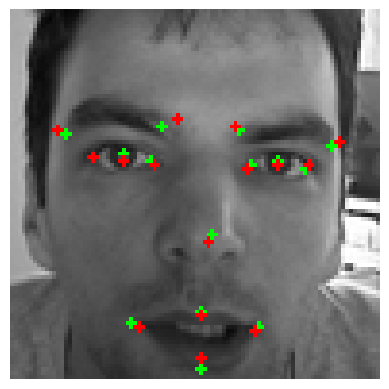

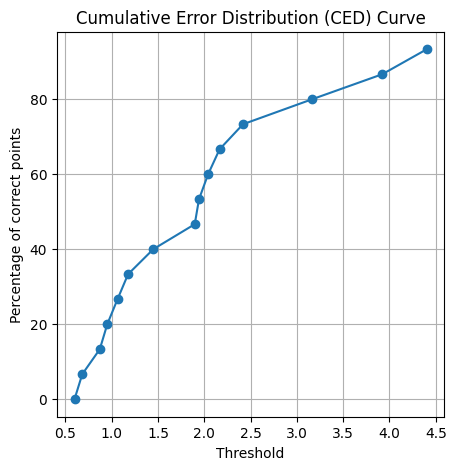

true_x  detected_x     true_y  detected_y  \
left_eye_center          69.680748        69.0  39.968748        40.0   
right_eye_center         29.183551        29.0  37.563364        39.0   
left_eye_inner_corner    62.864299        61.0  40.169271        41.0   
left_eye_outer_corner    76.898243        77.0  41.171888        40.0   
right_eye_inner_corner   36.401047        37.0  39.367626        40.0   
right_eye_outer_corner   21.765533        21.0  38.565533        38.0   
left_eyebrow_inner_end   59.766280        58.0  31.651290        30.0   
left_eyebrow_outer_end   83.313645        85.0  35.358056        34.0   
right_eyebrow_inner_end  39.408000        43.0  30.546393        28.0   
right_eyebrow_outer_end  14.949084        12.0  32.150131        31.0   
nose_tip                 52.468486        51.0  58.800000        60.0   
mouth_left_corner        64.869084        63.0  82.471178        83.0   
mouth_right_corner       31.990430        33.0  81.669084        82.0   
mouth_center_top_lip     49.308112        49.0  78.487626        79.0   
mouth_center_bottom_lip  49.432374        49.0  93.898766        90.0   

                                                            diff_xy  \
left_eye_center          (0.6807476636000018, -0.03125233640000147)   
right_eye_center         (0.18355140190000085, -1.4366355140000024)   
left_eye_inner_corner     (1.8642990653999973, -0.8307289720000028)   
left_eye_outer_corner    (-0.10175700930000176, 1.1718878504999992)   
right_eye_inner_corner   (-0.5989532709999992, -0.6323738318000025)   
right_eye_outer_corner     (0.7655327103000005, 0.5655327102999976)   
left_eyebrow_inner_end     (1.7662803738000008, 1.6512897196000011)   
left_eyebrow_outer_end     (-1.686355140200007, 1.3580560747999968)   
right_eyebrow_inner_end   (-3.5919999999999987, 2.5463925234000016)   
right_eyebrow_outer_end     (2.9490841120999995, 1.150130841100001)   
nose_tip                  (1.4684859812999989, -1.2000000000000028)   
mouth_left_corner         (1.8690841120999977, -0.5288224299000035)   
mouth_right_corner       (-1.009570093499999, -0.33091588790000515)   
mouth_center_top_lip     (0.30811214949999766, -0.5123738318000051)   
mouth_center_bottom_lip    (0.43237383179999966, 3.898766355099994)   

                         euclidean_distance        mse       mae      rmse  \
left_eye_center                    0.681465   0.464394  0.712000  0.681465   
right_eye_center                   1.448314   2.097613  1.620187  1.448314   
left_eye_inner_corner              2.041010   4.165722  2.695028  2.041010   
left_eye_outer_corner              1.176297   1.383676  1.273645  1.176297   
right_eye_inner_corner             0.871000   0.758642  1.231327  0.871000   
right_eye_outer_corner             0.951771   0.905868  1.331065  0.951771   
left_eyebrow_inner_end             2.417955   5.846504  3.417570  2.417955   
left_eyebrow_outer_end             2.165204   4.688110  3.044411  2.165204   
right_eyebrow_inner_end            4.403019  19.386579  6.138393  4.403019   
right_eyebrow_outer_end            3.165422  10.019898  4.099215  3.165422   
nose_tip                           1.896431   3.596451  2.668486  1.896431   
mouth_left_corner                  1.942454   3.773129  2.397907  1.942454   
mouth_right_corner                 1.062420   1.128737  1.340486  1.062420   
mouth_center_top_lip               0.597880   0.357460  0.820486  0.597880   
mouth_center_bottom_lip            3.922668  15.387326  4.331140  3.922668   

                         pck01  pck03  pck05   pck1  
left_eye_center            0.0    0.0    0.0  100.0  
right_eye_center           0.0    0.0    0.0    0.0  
left_eye_inner_corner      0.0    0.0    0.0    0.0  
left_eye_outer_corner      0.0    0.0    0.0    0.0  
right_eye_inner_corner     0.0    0.0    0.0  100.0  
right_eye_outer_corner     0.0    0.0    0.0  100.0  
left_eyebrow_inner_end     0.0    0.0    0.0    0.0  
left_eyebrow_outer_end     0.0    0.0    

In [27]:
# ВЫБЕРИ НОМЕР ИЗОБРАЖЕНИЯ
pic = 5

sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
visualize_prediction(sample_image, prediction[pic])
area_under_ced(prediction[pic].euclidean_distance, print=True)

prediction[pic]

In [28]:
my_metric.iloc[1]

euclidean_distance     1.173605
mse                    1.779025
mae                    1.483971
rmse                   1.173605
pck01                  0.000000
pck03                  0.000000
pck05                 20.000000
pck1                  40.000000
r2_x                   0.996995
r2_y                   0.997111
auc                    1.540525
Name: 2, dtype: float64

### Выбор метрики для определения качества детектирования

- **euclidean_distance** 
- **mse** среднеквадратичное отклонение
- **mae** средняя абсолютная ошибка
- **pck** на euclidean_distance с порогами 0.1, 0.3, 0.5, 1.0
- **r2_x** степень отклонения по x (Наилучший результат стремится к 1)
- **r2_y** степень отклонения по y (Наилучший результат стремится к 1)
- **auc** на euclidean_distance

In [40]:
metric = "euclidean_distance"
num_top = 5

print(f"Доступные метрики: {my_metric.columns.to_list()}")

Доступные метрики: ['euclidean_distance', 'mse', 'mae', 'pck01', 'pck03', 'pck05', 'pck1', 'r2_x', 'r2_y', 'auc']


In [41]:
def print_top(top):
    for pic, value in top:
        print(f"image {pic}: {value}")
        sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
        visualize_prediction(sample_image, prediction[pic])
        print(f"Area Under the CED Curve (AUC CED): {area_under_ced(prediction[pic].euclidean_distance)}")

### Наихудшее качество детектирования по метрике евклидова расстояния

Как видно из изображений, наихудший результат детектирования не всегда говорит о проблеме в модели, а может показывать, что у нас неверно размечены тестовые данные.

image 1907: 39.72702738990525


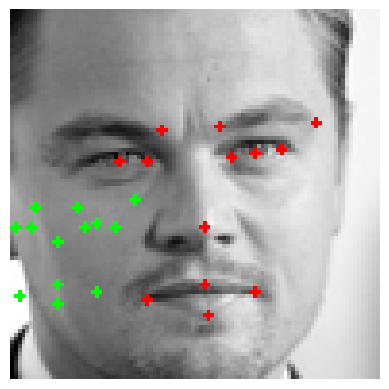

Area Under the CED Curve (AUC CED): 10.767491062605
image 1877: 33.71235701276306


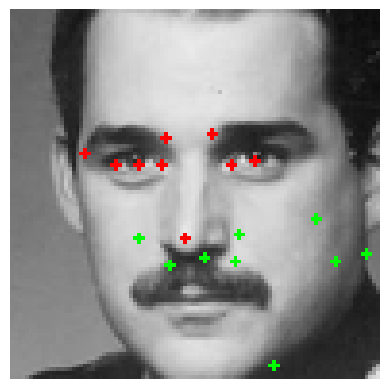

Area Under the CED Curve (AUC CED): 6.520517674619664
image 2199: 22.454035451877765


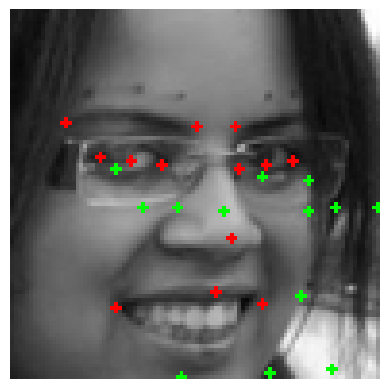

Area Under the CED Curve (AUC CED): 3.315886826153137
image 5933: 20.883161989666917


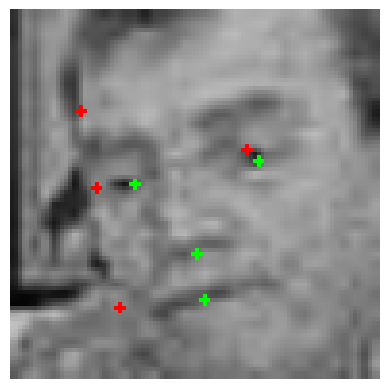

Area Under the CED Curve (AUC CED): 7.735814562946903
image 1953: 16.83310343667811


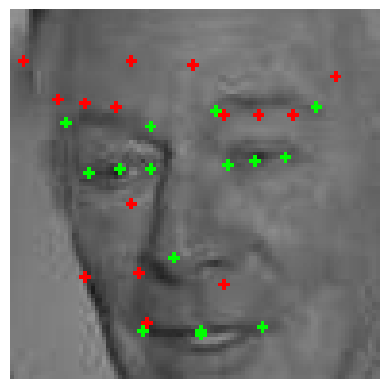

Area Under the CED Curve (AUC CED): 5.3802564361547915


In [42]:
top_worst_detection = sorted(my_metric[metric].items(), key=lambda x: x[1], reverse=True)[:num_top]
print_top(top_worst_detection) 

### Наилучшее качество детектирования по метрике евклидова расстояния

image 1259: 0.9799947114054232


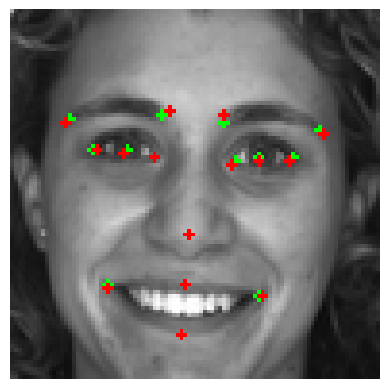

Area Under the CED Curve (AUC CED): 1.420550108643356
image 1566: 1.032893671107836


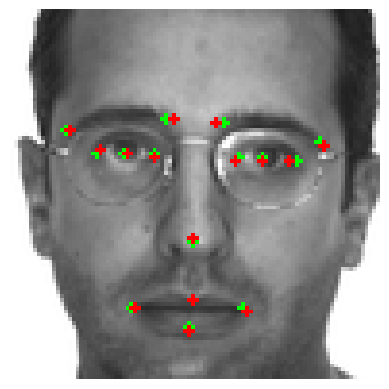

Area Under the CED Curve (AUC CED): 1.2978175614361729
image 2125: 1.043057013659586


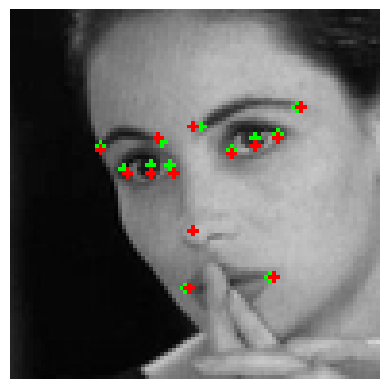

Area Under the CED Curve (AUC CED): 1.1837890552332255
image 1240: 1.0718036623278047


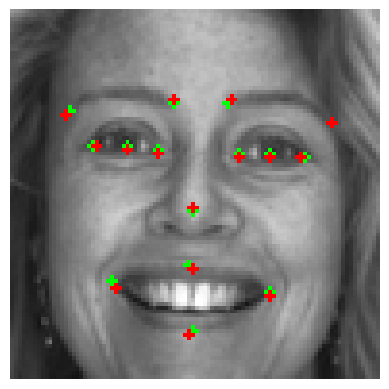

Area Under the CED Curve (AUC CED): 0.6907031707266321
image 884: 1.076017659572318


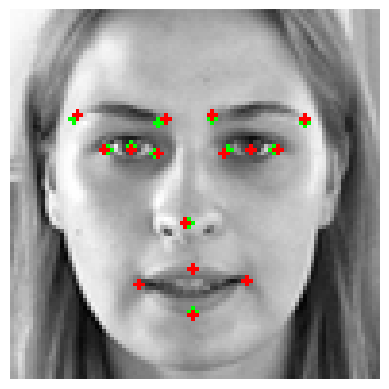

Area Under the CED Curve (AUC CED): 0.9837020239516504


In [43]:
top_best_detection = sorted(my_metric[metric].items(), key=lambda x: x[1], reverse=False)[:num_top]
print_top(top_best_detection)

# 3. Работа с инструментами разметки

Мы видим, что модель некоторые точки неверно детектирует на скачанных нами лицах и мы хотим отправить эти данные на разметку человеком. Для этого мы хотим в инструмент для разметки данных загрузить изображения и предсказания модели для последующего исправления людьми. Соответственно в этом задании нужно:

1. завести если нет аккаунт на сервисе supervisely

2. почитать документацию и разобраться с SDK/Python-API для supervisely

3. написать код для загрузки данных в supervisely (в этом же jupyter-notebook)

4. загрузить 5-10 изображений и предсказаний модели в supervisely и вставить скриншот с работающего сервиса

5. замерьте скорость разметки и оцените время разметки с нуля и время доразметки результатов работы модели


#### Настройка проекта

Перед началом необходимо создать **workspace** и скопировать **workspace_id** = **ID**

In [3]:
api = sly.Api.from_env()
project = api.project.create(workspace_id=305339, name="one1")  
dataset = api.dataset.create(project.id, "dataset-kaggle-worst")

dataset_for_download = top_worst_detection
# dataset_for_download = list(my_metric[metric].items())[:10]

temp_dir = 'data/kaggle/facial-keypoints-detection/working'

#### Загрузка данных в Supervisely

In [ ]:
# Сохранение картинок в png на pc
def download_dataset_to_pc(dataset_for_download, train_df, temp_dir):
    for pic, value in dataset_for_download:
        sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
        image_filename = f'image_{pic}.png'
        image_path = os.path.join(temp_dir, image_filename)
        cv2.imwrite(image_path, sample_image)


# Создание аннотаций
def create_annotation(image_id, points_df, image_shape = (96,96)):
    
    labels = []
    # Создание меток для предсказанных точек
    for idx, row in points_df.iterrows():
        point_pred = sly.Point(row['detected_y'], row['detected_x'])  
        label_pred = sly.Label(point_pred, sly.ObjClass(name=f"{idx}_pred", geometry_type=sly.Point))
        labels.append(label_pred)

    # Создание меток для "истинных" точек
    for idx, row in points_df.iterrows():
        point_true = sly.Point(row['true_y'], row['true_x']) 
        label_true = sly.Label(point_true, sly.ObjClass(name=str(idx), geometry_type=sly.Point))
        labels.append(label_true)

    annotation = sly.Annotation(img_size=[image_shape[0], image_shape[1]], labels=labels)

    ann_path = os.path.join('annotations', f'{image_id}.json')
    os.makedirs(os.path.dirname(ann_path), exist_ok=True)
    
    with open(ann_path, 'w') as f:
        json.dump(annotation.to_json(), f)

    return ann_path


In [ ]:
# Метаданные о классах
project_meta_json = api.project.get_meta(project.id)
project_meta = sly.ProjectMeta.from_json(project_meta_json)

# Загружаем аннотации и картинки в Supervisely
for pic, value in dataset_for_download:
    
    sample_image = cv2.cvtColor(train_df.iloc[pic]['Image'], cv2.COLOR_BGR2RGB)
    image_filename = f'image_{pic}.png'
    image_path = os.path.join(temp_dir, image_filename)

    points = prediction[pic]
    ann_path = create_annotation(pic, points[["detected_x","detected_y", "true_x", "true_y"]])
    
    # Загрузка картинки
    cv2.imwrite(image_path, sample_image)
    img_info = api.image.upload_path(dataset.id, image_filename, image_path)

    # Загрузка аннотации
    if os.path.exists(ann_path):
        with open(ann_path) as f:
            ann_json = json.load(f)
        ann = sly.Annotation.from_json(ann_json, project_meta)
        api.annotation.upload_ann(img_info.id, ann)

    # Удаление временных файлов
    os.remove(image_path)
    os.remove(ann_path)

#### Скриншоты из сервиса Supervisely

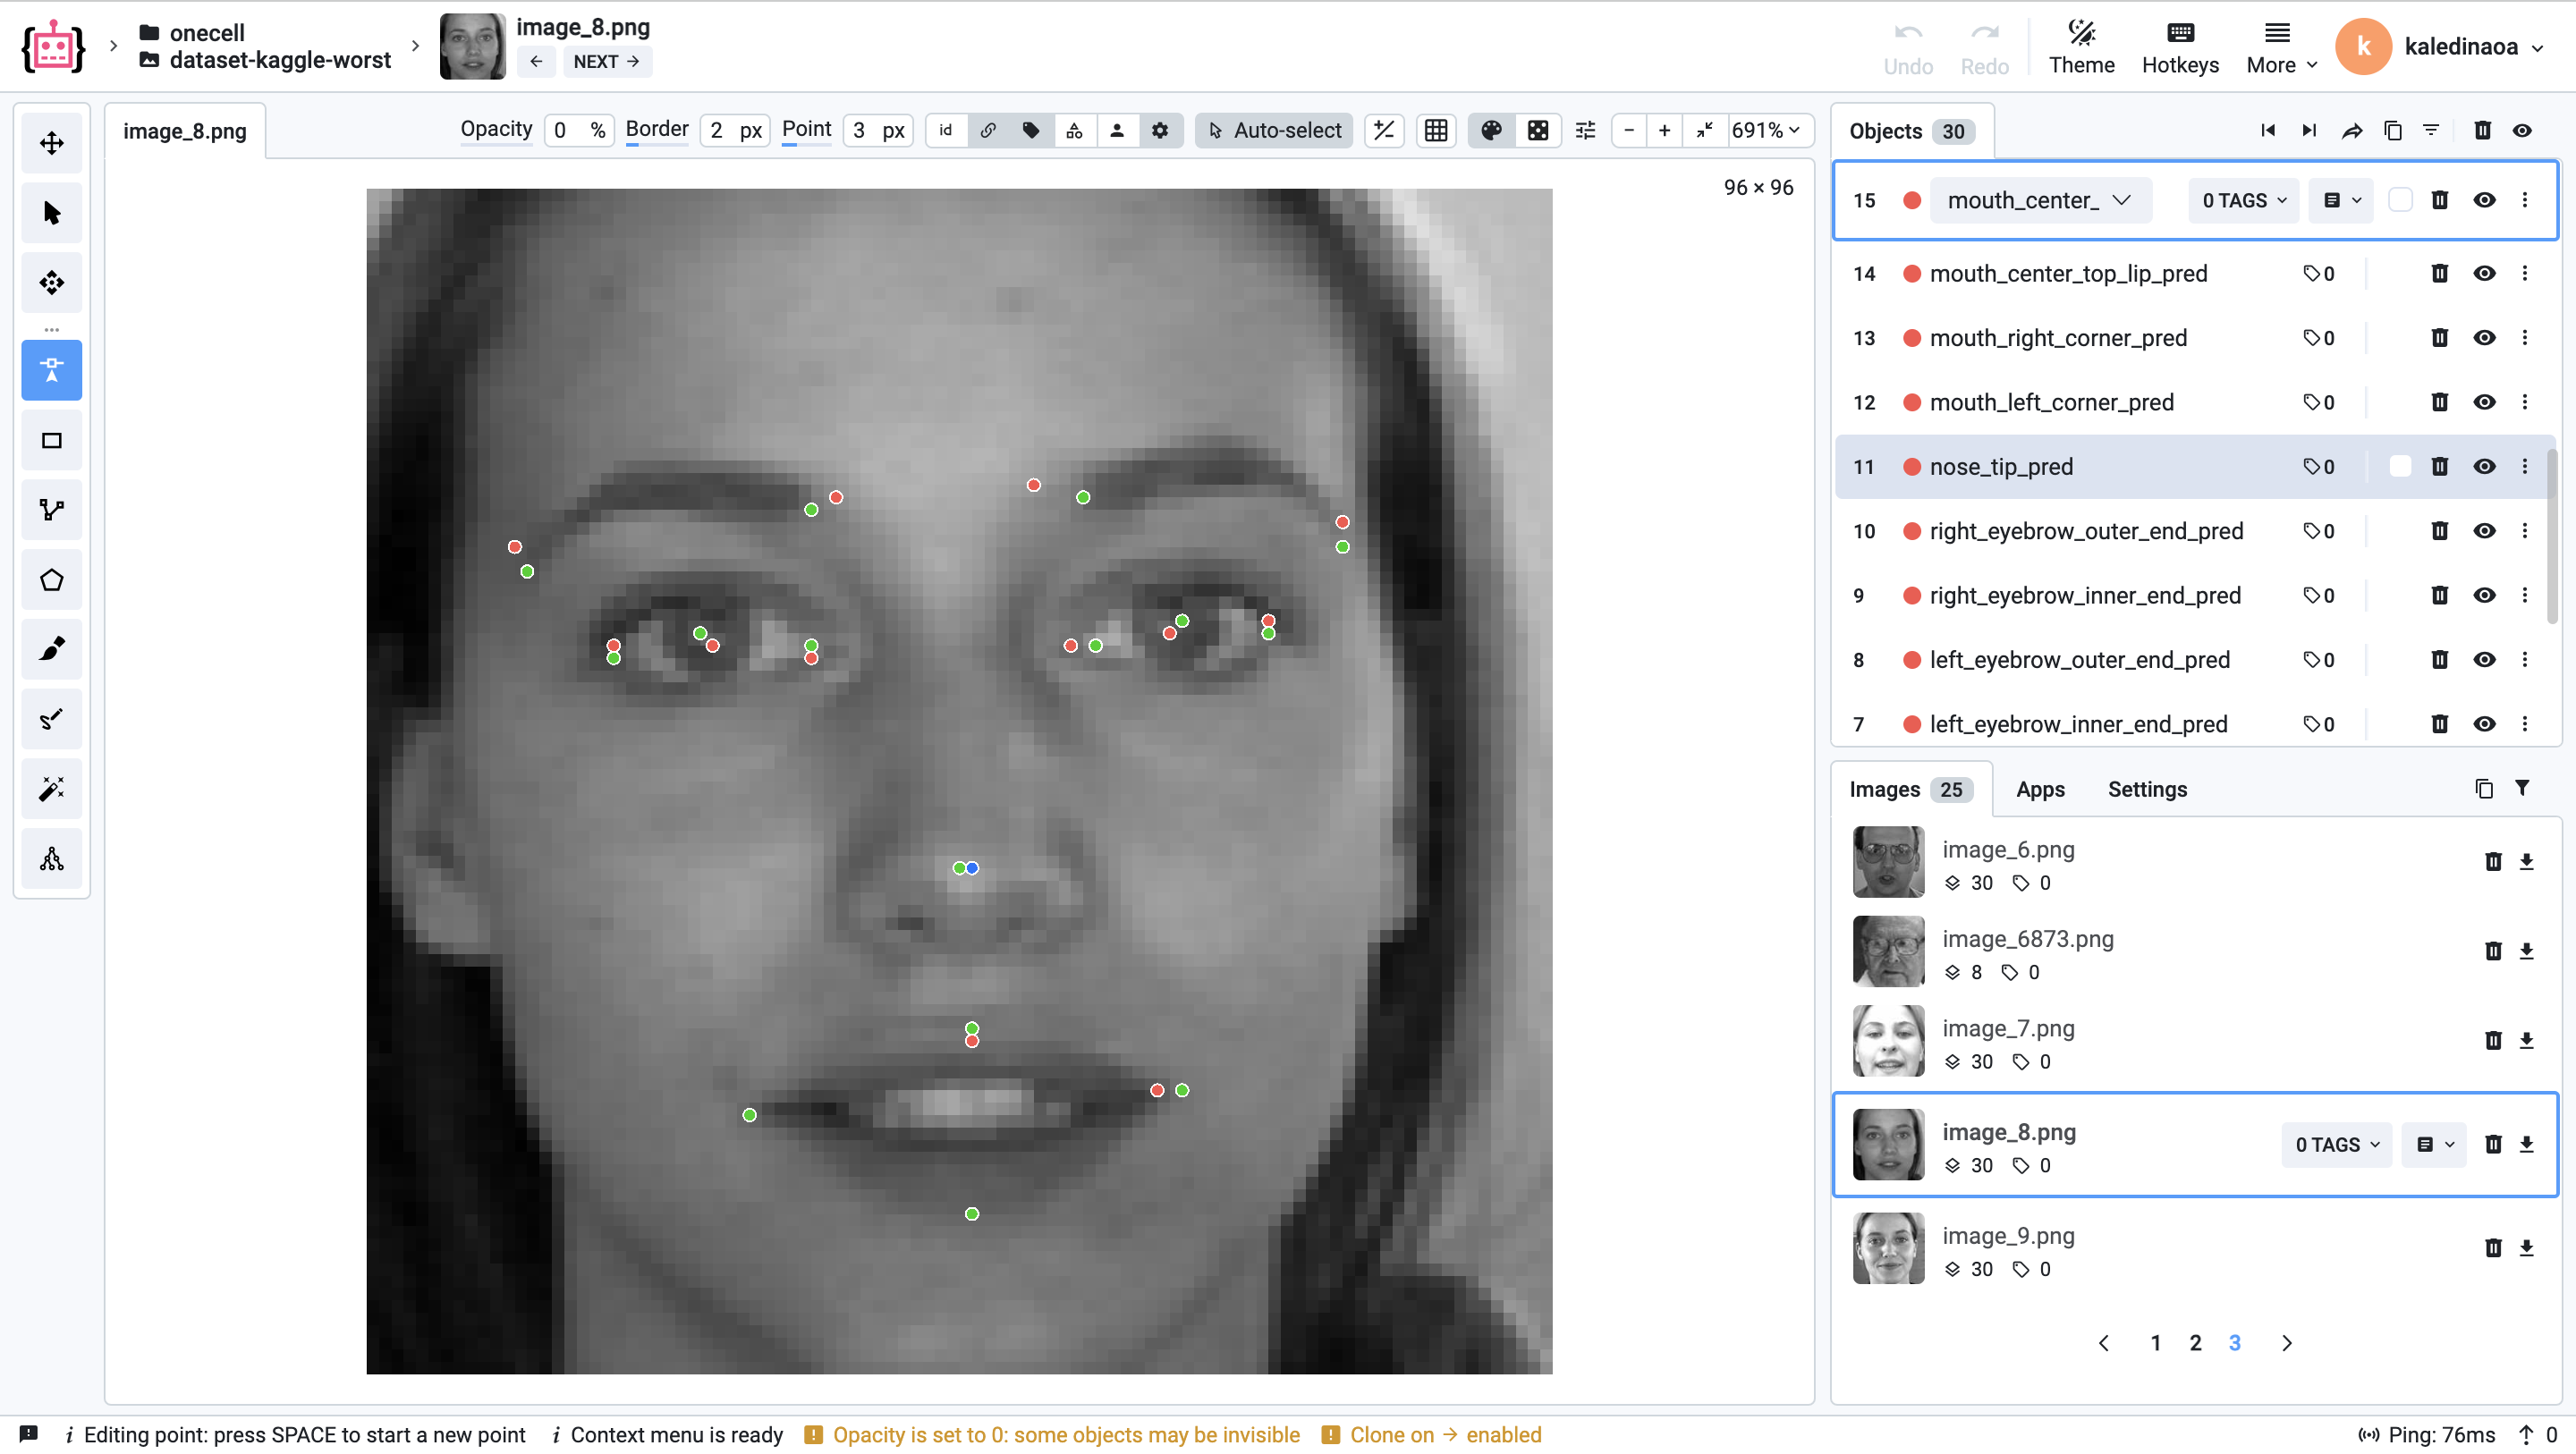

In [ ]:
Image(filename="./data/img/screen1.png")

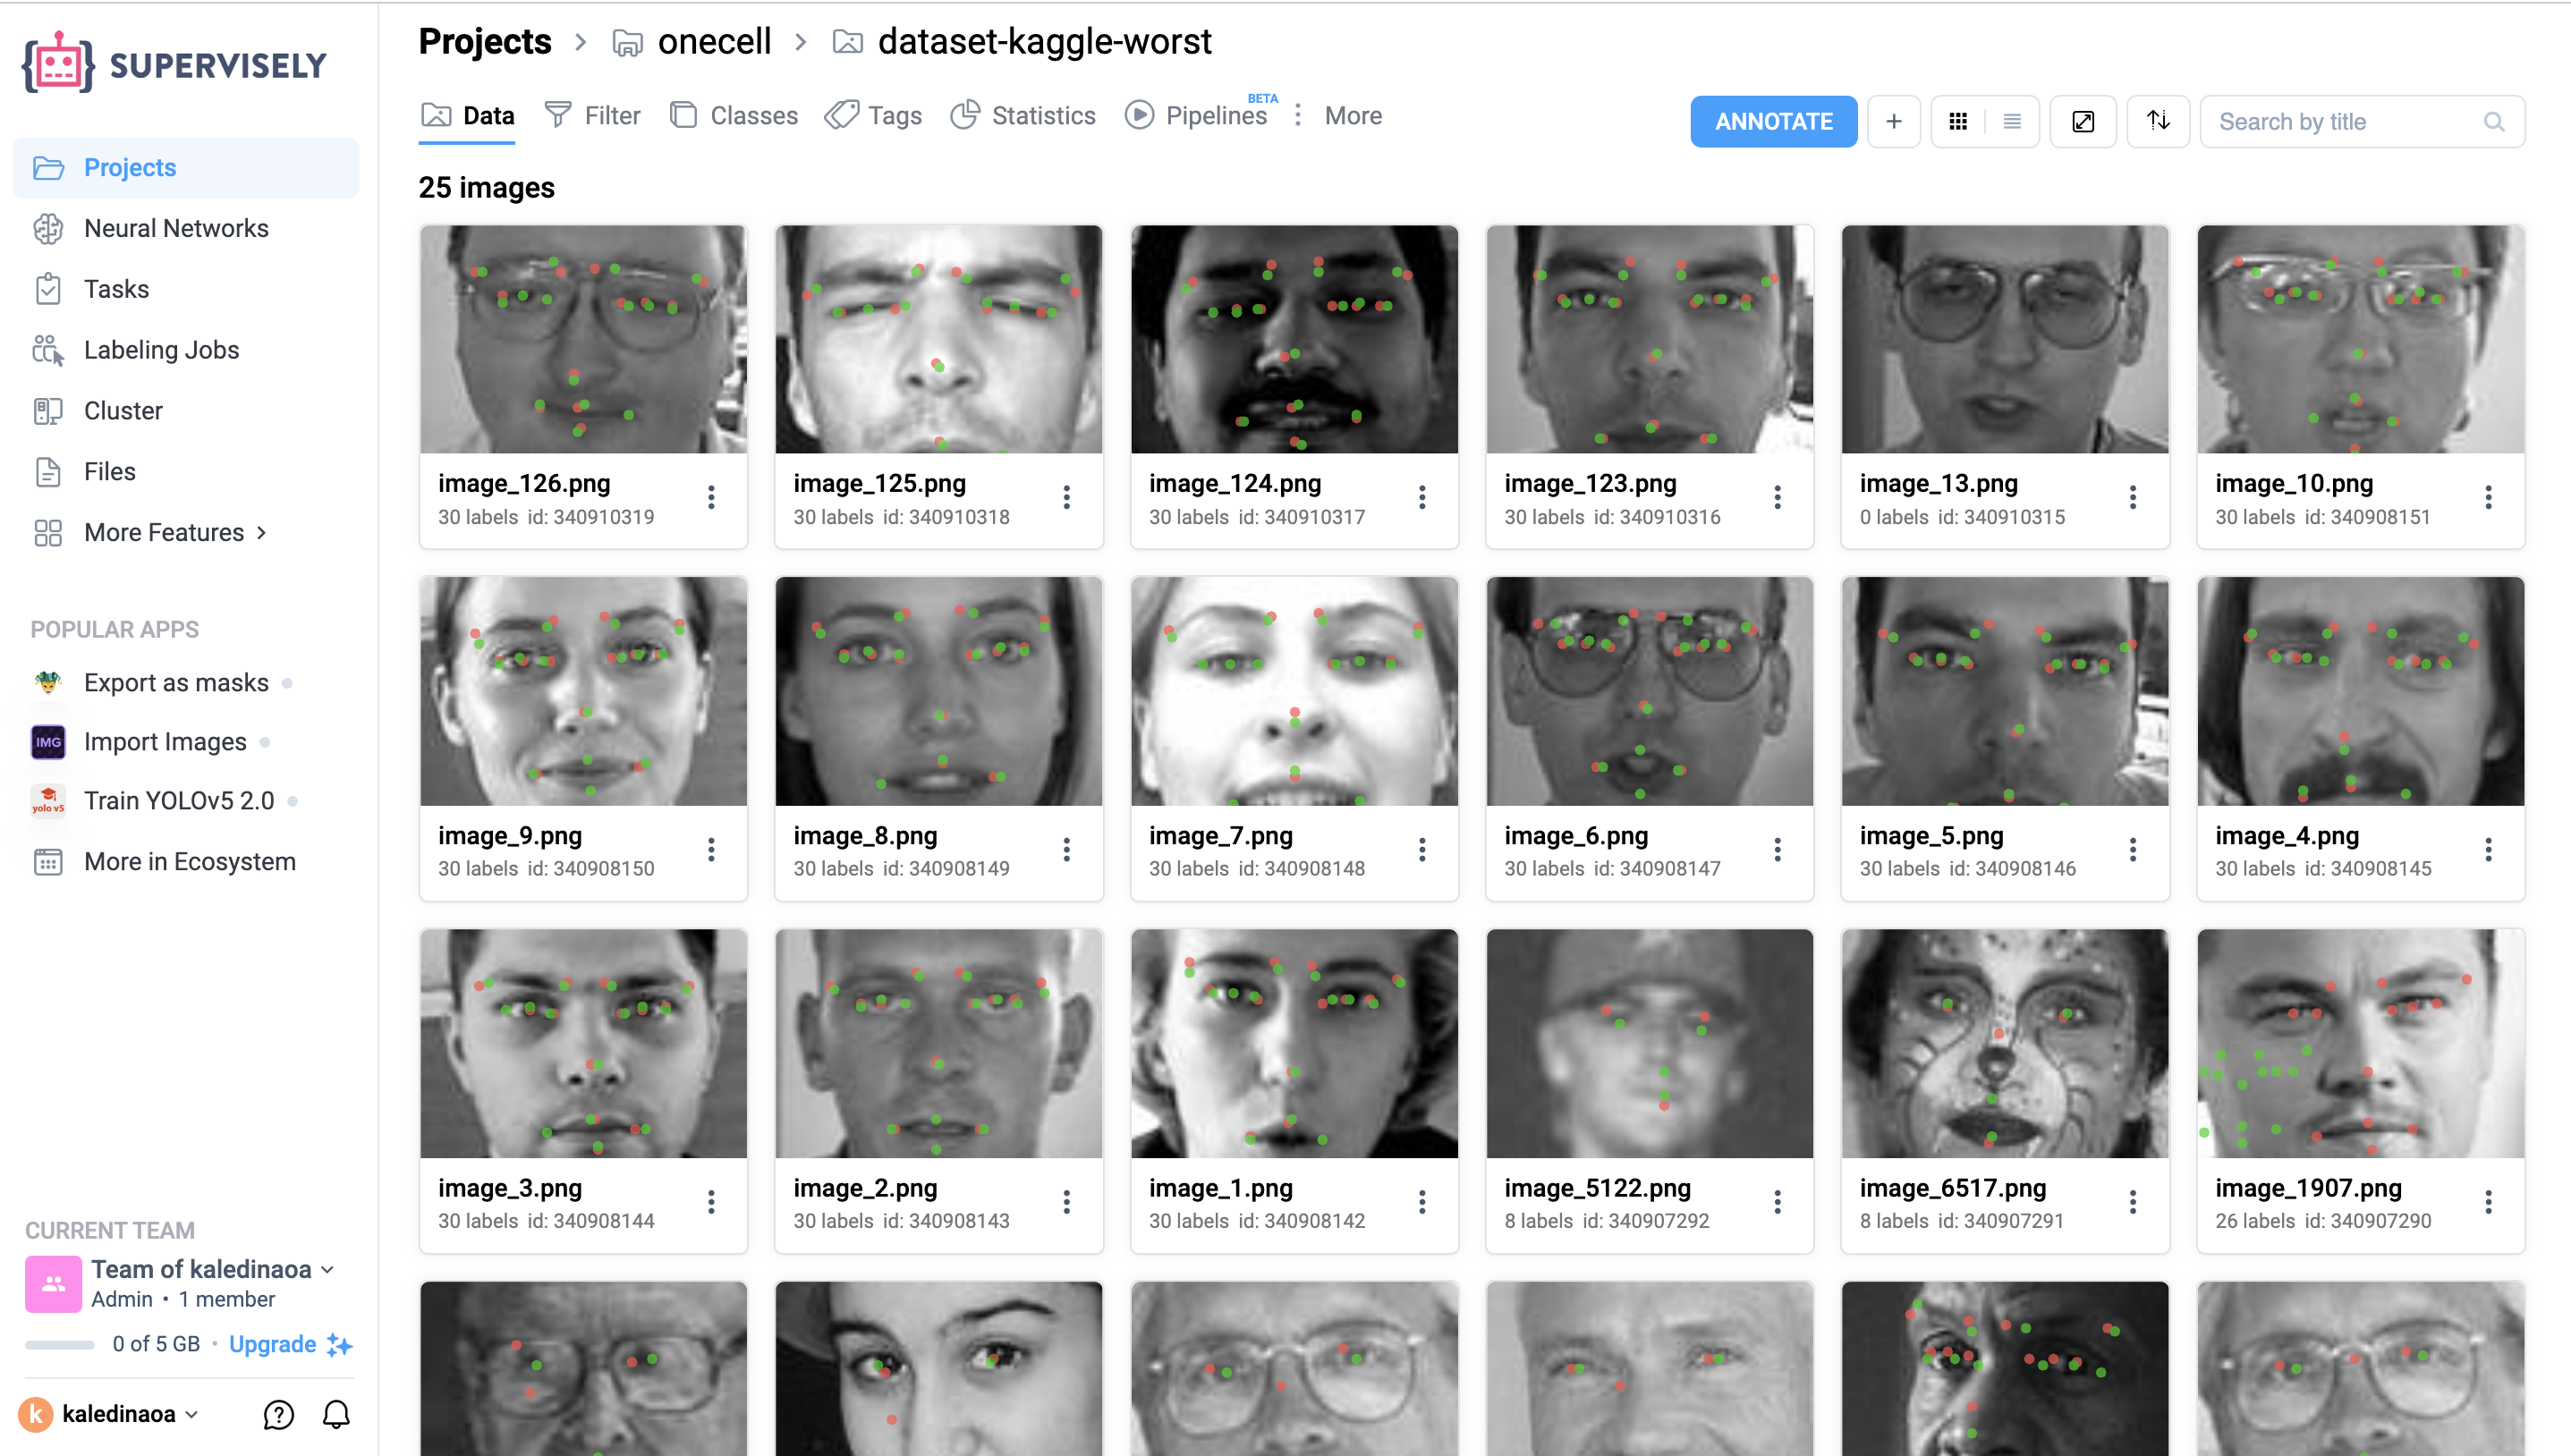

In [ ]:
Image(filename="./data/img/screen2.png")

#### Замер скорости разметки